In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats
import tabulate
from  matplotlib.ticker import FuncFormatter
import os
from pathlib import Path

sns.set_style("whitegrid")
pd.set_option("styler.format.decimal", ",")
pd.set_option("styler.format.precision", 2)
pd.set_option("styler.format.na_rep", "–")
cm = plt.cm.YlOrRd

subdirectory = Path("assets")
subdirectory.mkdir(exist_ok=True)

def write_figure(the_name):
    plt.savefig(subdirectory / f"figure-{the_name}.svg")

def write_table(df, the_name, caption="", heatmap=False, axis=None):
    style = df.style if not heatmap else df.style.background_gradient(axis=axis, cmap=cm)
    with (subdirectory / f"table-{the_name}.tex").open(mode="w") as f:
        f.write(
            (style).highlight_null(props="background-color:white; color:white;").to_latex(
                convert_css=True, 
                hrules=True,
                sparse_index=False,
                environment="longtable", 
                position="!hbt", 
                caption=caption, 
                label="tbl:"+the_name
            )
        )
    with (subdirectory / f"table-{the_name}.html").open(mode="w") as f:
        f.write((style).highlight_null(props="opacity:0").to_html(sparse_index=False))
    with (subdirectory / f"table-{the_name}.md").open(mode="w") as f:
        if caption:
            f.write(f"Table: {caption}\n\n")
        f.write(df.to_markdown(floatfmt=".2f").replace("nan", "\u00a0").replace(".00", "   ").replace(".", ",")) #ma

In [2]:
print("ⲟⲩϫⲁⲓ ⲡⲕⲟⲥⲙⲟⲥ!")

ⲟⲩϫⲁⲓ ⲡⲕⲟⲥⲙⲟⲥ!


## Transliteration from Greek to Coptic

In [3]:
import unicodedata
import re

greek_to_coptic = {
  'α': 'ⲁ',
  'β': 'ⲃ',
  'γ': 'ⲅ', 
  'δ': 'ⲇ',
  'ε': 'ⲉ',
  'ζ': 'ⲍ',
  'η': 'ⲏ',
  'θ': 'ⲑ',
  'ϑ': 'ⲑ',
  'ι': 'ⲓ',
  'κ': 'ⲕ',
  'λ': 'ⲗ',
  'μ': 'ⲙ',
  'ν': 'ⲛ',
  'ξ': 'ⲝ',
  'ο': 'ⲟ',
  'π': 'ⲡ',
  'ρ': 'ⲣ',
  'σ': 'ⲥ',
  'τ': 'ⲧ',
  'υ': 'ⲩ',
  'φ': 'ⲫ',
  'χ': 'ⲭ',
  'ψ': 'ⲯ',
  'ω': 'ⲱ',
  'ς': 'ⲥ',
  'ϗ': 'ⳤ',
  '\u0314': 'ϩ',
  '\u0345': 'ⲓ',
}

vowels = {"ⲁ", "ⲉ", "ⲏ", "ⲓ", "ⲟ", "ⲱ","ⲩ"}
consonants = {"ⲃ", "ⲅ", "ⲇ", "ⲍ", "ⲏ", "ⲑ", "ⲕ", "ⲗ", "ⲙ", "ⲛ", "ⲝ", "ⲡ", "ⲣ", "ⲥ", "ⲧ", "ⲫ", "ⲭ", "ⲯ", "ϩ", "ϣ", "ϭ", "ϥ", "ϧ", "ϫ"}

greek_to_coptic_ord = {ord(greek): ord(coptic) for greek, coptic in greek_to_coptic.items()}

def transliterate(greek):
    normalized = unicodedata.normalize("NFD", greek)
    clean_spiritus_asper = lambda x: re.sub(r"^([ⲣⲁⲉⲏⲓⲟⲱⲩ]+)ϩ", r'ϩ\1', x)
    return clean_spiritus_asper(
        "".join(
            greek_to_coptic[character.lower()]
            for character in normalized
            if character.lower() in greek_to_coptic
        )
    )

In [4]:
transliterate("ῥᾳδίως")

'ϩⲣⲁⲓⲇⲓⲱⲥ'

In [5]:
df = pd.read_csv(os.getenv("ATTESTATIONS_CSV"))
df = df.set_index("id")

/tmp/ipykernel_597989/912060916.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.getenv("ATTESTATIONS_CSV"))


In [6]:
df

,quote_coptic,quote_english,orthography,encoding,coptic_lemma_id,coptic_lemma,coptic_lemma2,greek_lemma_id,greek_lemma,dialect,...,manuscript_text,earliest,latest,?,collection,material,dialectCode,dialect_group,code,name
id,,,,,,,,,,,,,,,,,,,,,
30,ⲛⲉⲟⲩⲁⲗⲉ[ⲕⲧ]ⲱⲣ ⲙⲟⲩⲧⲉ ⲙⲡⲁⲧⲕⲣ^[ⲁⲣ]ⲛⲁ^ ⲙⲙⲁⲉⲓ ⲛϣⲁⲙⲧ...,A rooster will not crow until you have ^denied...,[ⲁⲣ]ⲛⲁ,vb.ny-cr.auxy.obn,371,ⲁⲣⲛⲁ,ⲁⲣⲛⲁ,274,ἀρνέομαι,L5,...,Cambridge - Bible Society's Library pap. Q - G...,200.0,299.0,NaN,Cambridge - Bible Society's Library pap. Q,Papyrus,L5,Lycopolitan Dialects,L5,NaN
71613,ⲛⲉϥϩⲏⲛ ^ⲇⲉ^ ⲁϩⲟⲩⲛ ϫⲓ ⲡⲡⲁⲥⲭⲁ | ⲛ̄ⲛⲓⲟⲩⲧⲁⲉⲓ⸱ ⲁⲩⲱ ...,[…] ^and^ the passover of the Jews was approac...,ⲇⲉ,2fun,572,ⲇⲉ,ⲇⲉ,458,δέ,L5,...,Cambridge - Bible Society's Library pap. Q - G...,200.0,299.0,NaN,Cambridge - Bible Society's Library pap. Q,Papyrus,L5,Lycopolitan Dialects,L5,NaN
71614,ⲛⲉϥϩⲏⲛ ⲇⲉ ⲁϩⲟⲩⲛ ϫⲓ ⲡ^ⲡⲁⲥⲭⲁ^ ⲛ̄ⲛⲓⲟⲩⲧⲁⲉⲓ⸱ ⲁⲩⲱ ⲁⲓ...,[…] and the ^passover^ of the Jews was approac...,ⲡⲁⲥⲭⲁ,nn.m.sg.dtd,1907,ⲡⲁⲥⲭⲁ,ⲡⲁⲥⲭⲁ,1689,πάσχα,L5,...,Cambridge - Bible Society's Library pap. Q - G...,200.0,299.0,NaN,Cambridge - Bible Society's Library pap. Q,Papyrus,L5,Lycopolitan Dialects,L5,NaN
71615,ⲛⲉϥϩⲏⲛ ⲇⲉ ⲁϩⲟⲩⲛ ϫⲓ ⲡⲡⲁⲥⲭⲁ ⲛ̄ⲛ^ⲓⲟⲩⲧⲁⲉⲓ^⸱ ⲁⲩⲱ ⲁⲓ...,[…] and the passover of the ^Jews^ was approac...,ⲓⲟⲩⲧⲁⲉⲓ,nn.gen0.pl.dtd,1117,ⲓⲟⲩⲇⲁⲓ,ⲓⲟⲩⲇⲁⲓ,958,Ἰουδαῖος,L5,...,Cambridge - Bible Society's Library pap. Q - G...,200.0,299.0,NaN,Cambridge - Bible Society's Library pap. Q,Papyrus,L5,Lycopolitan Dialects,L5,NaN
71616,ⲁϥϭⲓ|ⲛⲉ ⲙ̄ⲙⲁⲩ ϩ︦ⲛ︦ ⲡ︦ⲣ︦ⲡⲉⲉ ⲉⲩϯ ⲁ|ⲃⲁⲗ ⲛ̄ⲛⲉϩⲁⲩ ⲙ...,He found them in the temple.selling oxen and s...,[ⲧⲣⲁ|ⲡⲉ]ⲍⲓⲧⲏⲥ,nn.gen0.pl.dtd,2477,ⲧⲣⲁⲡⲉⲍⲓⲧⲏⲥ,ⲧⲣⲁⲡⲉⲍⲓⲧⲏⲥ,2206,τραπεζίτης,L5,...,Cambridge - Bible Society's Library pap. Q - G...,200.0,299.0,NaN,Cambridge - Bible Society's Library pap. Q,Papyrus,L5,Lycopolitan Dialects,L5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201060,ⲁⲩⲱ ⲡⲙⲉⲣⲓⲧ⳿ ⲉϥⲟ̂ ⲛ̄ⲑⲉ ⲛ̄ⲟⲩϣⲏⲣⲉ ⲙ̄^ⲙⲟⲙⲟⲕⲉⲣⲱⲥ^,and the beloved is like a ^unicorn^'s young,ⲙⲟⲙⲟⲕⲉⲣⲱⲥ,nn.gen0.num0.dt0.cnst3,4283,ⲙⲟⲛⲟⲕⲉⲣⲱⲥ,ⲙⲟⲛⲟⲕⲉⲣⲱⲥ,5093,μονόκερως,S,...,Nagel 2022b - - Psalms,NaN,NaN,NaN,Nagel 2022b -,NaN,S,Sahidic Dialects,S,Sahidic
201061,[…] ⲛ̄ϥϩⲁⲣⲉϩ ⲉⲣⲟϥ ⲉ̣ϥϥⲓ ⲙⲡⲣⲟⲟⲩϣ ⲛⲛⲉϥⲉⲕⲕⲗⲏⲥⲓⲁ ⲉ...,[…] and that He may protect him as he takes ca...,ⲕⲁⲑⲩⲡⲟⲧⲁⲥⲥⲉ,vb.cnj.auxy.obn,7381,ⲕⲁⲑⲩⲡⲟⲧⲁⲥⲥⲉ,ⲕⲁⲑⲩⲡⲟⲧⲁⲥⲥⲉ,5582,καθυποτάσσω,S,...,Khartum - National Museum 24338 - Foundation i...,700.0,719.0,AD 707 Aug 28,Khartum - National Museum 24338,Sandstone,S,Sahidic Dialects,S,Sahidic
201062,[…] ϩⲓⲧⲛ̄ ⲧⲙ̅ⲛⲧϥⲁⲓⲣⲟⲟⲩϣ ⲁⲩⲱ ⲛⲣⲉϥⲉⲡⲓⲑⲩⲙⲉⲓ ⲉⲛⲁⲡⲛ...,[…] through the care and the desire for the th...,ⲡⲣⲟⲉⲇⲣⲟⲥ,nn.m.sg.dtd,7382,ⲡⲣⲟⲉⲇⲣⲟⲥ,ⲡⲣⲟⲉⲇⲣⲟⲥ,5586,πρόεδρος,S,...,Khartum - National Museum 24338 - Foundation i...,700.0,719.0,AD 707 Aug 28,Khartum - National Museum 24338,Sandstone,S,Sahidic Dialects,S,Sahidic


In [7]:
df[["manuscript_text", "earliest", "latest"]].set_index("manuscript_text").drop_duplicates()

,earliest,latest
manuscript_text,,
Cambridge - Bible Society's Library pap. Q - Gospel of John,200.0,299.0
Papyrus Nag Hammadi C 002 - Genesis,200.0,399.0
London - British Library Or 4919(5) - Lamentations,NaN,NaN
Leipzig - Universität - Papyrus- und Ostrakasammlung P.Lips. Inv. 2299 - Exodus Apocryphon,200.0,499.0
Moscow - Pushkin Museum I.1.b.523 - P.MoscowCopt 90,200.0,1119.0
...,...,...
Berlin - Ägyptisches Museum P. 8324 - BKU I 18 (Healing amulet),NaN,699.0
London - British Library Or. 5525 - P.Lond.Copt. 1 524 (magical text to protect a woman and her children),NaN,899.0
London - British Library Or. 6800 - Colophon with prayer for Mena bishop of Keft,1000.0,1033.0


In [8]:
df[df["manuscript_text"] == "London - British Library Add MS 5114 - Pistis Sophia, Book 2"]

,quote_coptic,quote_english,orthography,encoding,coptic_lemma_id,coptic_lemma,coptic_lemma2,greek_lemma_id,greek_lemma,dialect,...,manuscript_text,earliest,latest,?,collection,material,dialectCode,dialect_group,code,name
id,,,,,,,,,,,,,,,,,,,,,
128794,ⲡⲙⲉϩⲥⲛⲁⲩ ⲛ̄^ⲧⲟⲙⲟⲥ^ ⲛ̄ⲧⲡⲓⲥⲧⲓⲥ ⲥⲟⲫⲓⲁ \,NaN,ⲧⲟⲙⲟⲥ,nn.m-env.sg-env.dtd-env.cnst25-o,2466,ⲧⲟⲙⲟⲥ,ⲧⲟⲙⲟⲥ,2197,τόμος,S,...,London - British Library Add MS 5114 - Pistis ...,NaN,NaN,NaN,NaN,NaN,S,Sahidic Dialects,S,Sahidic
128803,ⲡⲙⲉϩⲥⲛⲁⲩ ⲛ̄ⲧⲟⲙⲟⲥ ⲛ̄ⲧⲡⲓⲥⲧⲓⲥ ^ⲥⲟⲫⲓⲁ^ \,NaN,ⲥⲟⲫⲓⲁ,nn.gen0.num0.dt0,2244,ⲥⲟⲫⲓⲁ,ⲥⲟⲫⲓⲁ,2007,σοφία,S,...,London - British Library Add MS 5114 - Pistis ...,NaN,NaN,NaN,NaN,NaN,S,Sahidic Dialects,S,Sahidic
129023,ⲁϥⲉⲓ⳿ ϩⲱⲱϥ ⲉⲑⲏ ⲛ̄ϭⲓ ⲓ̈ⲱϩⲁⲛⲛⲏⲥ ⲡⲉϫⲁϥ ϫⲉ ⲡϫⲟⲉⲓⲥ ...,NaN,ⲕⲉⲗⲉⲩⲉ,NaN,1268,ⲕⲉⲗⲉⲩⲉ,ⲕⲉⲗⲉⲩⲉ,1102,κελεύω,S,...,London - British Library Add MS 5114 - Pistis ...,NaN,NaN,NaN,NaN,NaN,S,Sahidic Dialects,S,Sahidic
129024,ⲁϥⲉⲓ⳿ ϩⲱⲱϥ ⲉⲑⲏ ⲛ̄ϭⲓ ⲓ̈ⲱϩⲁⲛⲛⲏⲥ ⲡⲉϫⲁϥ ϫⲉ ⲡϫⲟⲉⲓⲥ ...,NaN,ⲡⲣⲟⲫⲏⲧⲉⲩⲉ,vb.1prf-rl.auxn.ob1.ob11,2939,ⲡⲣⲟⲫⲏⲧⲉⲩⲉ,ⲡⲣⲟⲫⲏⲧⲉⲩⲉ,2576,προφητεύω,S,...,London - British Library Add MS 5114 - Pistis ...,NaN,NaN,NaN,NaN,NaN,S,Sahidic Dialects,S,Sahidic
129025,ⲁϥⲟⲩⲱϣ︦ⲃ︦ ^ⲇⲉ^ ⲛ̄ϭⲓ ⲓ︦[ⲏⲥⲟⲩ]ⲥ︦ ⲡⲉϫⲁϥ ⲛ̄ⲓ̈ⲱϩⲁⲛⲛ...,NaN,ⲇⲉ,2fun,572,ⲇⲉ,ⲇⲉ,458,δέ,S,...,London - British Library Add MS 5114 - Pistis ...,NaN,NaN,NaN,NaN,NaN,S,Sahidic Dialects,S,Sahidic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142658,ⲧⲉ^ⲅⲛⲱⲥⲓⲥ^ ⲅⲁⲣ ⲙ̄ⲡⲥⲟⲟⲩⲛ ⲙ̄ⲡⲓⲁⲧ\ϣⲁϫⲉ ⲉⲣⲟ[ϥ] ⲛ̄ⲧ...,For the ^gnosis^ of the knowledge of the lneff...,ⲅⲛⲱⲥⲓⲥ,nn.f.sg.dtd,551,ⲅⲛⲱⲥⲓⲥ,ⲅⲛⲱⲥⲓⲥ,438,γνῶσις,S,...,London - British Library Add MS 5114 - Pistis ...,NaN,NaN,NaN,NaN,NaN,S,Sahidic Dialects,S,Sahidic
142659,ⲧⲉⲅⲛⲱⲥⲓⲥ ^ⲅⲁⲣ^ ⲙ̄ⲡⲥⲟⲟⲩⲛ ⲙ̄ⲡⲓⲁⲧ\ϣⲁϫⲉ ⲉⲣⲟ[ϥ] ⲛ̄ⲧ...,NaN,ⲅⲁⲣ,NaN,533,ⲅⲁⲣ,ⲅⲁⲣ,415,γάρ,S,...,London - British Library Add MS 5114 - Pistis ...,NaN,NaN,NaN,NaN,NaN,S,Sahidic Dialects,S,Sahidic
142660,ⲧⲉⲅⲛⲱⲥⲓⲥ ⲅⲁⲣ ⲙ̄ⲡⲥⲟⲟⲩⲛ ⲙ̄ⲡⲓⲁⲧ\ϣⲁϫⲉ ⲉⲣⲟ[ϥ] ⲛ̄ⲧⲁⲓ...,NaN,ⲙⲉⲣⲟⲥ,nn.[gen0.sg.dti],1599,ⲙⲉⲣⲟⲥ,ⲙⲉⲣⲟⲥ,1391,μέρος,S,...,London - British Library Add MS 5114 - Pistis ...,NaN,NaN,NaN,NaN,NaN,S,Sahidic Dialects,S,Sahidic


In [9]:
pd.DataFrame(df[pd.isna(df["earliest"]) & pd.isna(df["latest"])]["manuscript_text"].value_counts())

,count
manuscript_text,
"London - British Library Add MS 5114 - Pistis Sophia, Book 2",3486
"London - British Library Add MS 5114 - Pistis Sophia, Book 3",3475
INTF Acta* (sahidic) - Acts of the Apostles,2762
New York - The Morgan Library and Museum M.579 - Life of St. Antony,2754
Oxford - Bodleian Library MS Bruce 96 - Book of the Great Mysterious Discourse,2709
...,...
"Abydos, Osirieion, in situ - SB Kopt. III 1521 (Recording of the Nile flood)",1
Cairo - Coptic Museum inv. no. unknown - SB Kopt. III 1443 (List of wine and items),1
"Abydos, Osirieion, in situ - SB Kopt. III 1536 (Inscription by Mary the novice nun)",1


In [10]:
df["date_approximate"] = df["latest"] + df["earliest"] / 2
# TODO use whatever is available if one is NaN

In [82]:
df_simple = df[["orthography", "coptic_lemma", "greek_lemma", "dialect", "date_approximate"]]
df_simple = df_simple.dropna()

# transliterate the greek lemmata into coptic
df_simple["greek_lemma"] = df_simple["greek_lemma"].apply(transliterate)

# remove incertain or abbreviated coptic lemmata
#df_simple = df_simple[~df_simple["coptic_lemma"].str.contains(r"\[ⲟⲩⲅⲅⲓⲁ\]|incertum|/|\?")]

df_simple = df_simple[~(
    df_simple["orthography"].str.contains("sic")
    | df_simple["orthography"].str.endswith(("/", "/̅", "/°")) # remove marked abbreviations
    | df_simple["orthography"].str.contains("\d|[….ⳇ⁄?ⳁ⳨ⲋ⳦⳥⳽]", regex=True) # remove lines with numbers or marked abbreviations
)]

df_simple["orthography_clean"] = (
    df_simple["orthography"]
    .str.strip() # remove extraneous whitespace
    .str.lower()
    .apply(lambda x: x.translate(greek_to_coptic_ord)) # convert greek letters that crept in
    .str.replace("ϊ", "ⲓ") # convert precombined accented greek letter
    .str.replace("[\u0305\u0304\ufe24\ufe25\ufe26\u2cf1\u2cf0\u0300]+", "", regex=True) # remove overlines
    .str.replace("[\u2CBB\u2CEF]", "ⲛ", regex=True) # normalize letter N (written as stroke)
    .str.replace("[ⳅⲹ]", "ⲍ", regex=True) # normalize letter Z
    .str.replace("\u001D|\u0314|\u200E|\u0486|\u02BE|\u2CFF|\u0307|\u0308|\u0301|\u0323|\u0304|\u1DCD|\u0302|\u0306" + "|" + r"col\.b|/|⟦.*?⟧|\\|\[|\]|[‖|´⸤⸥⸢⸣⁅⁆⸖'‹›`’`´:⸌⸍\⸳‧·•·ʾ*]", "", regex=True)
)

# remove prefixes and suffixes of coptic lemmata
df_simple["coptic_lemma"] = df_simple["coptic_lemma"].str.replace("^(ϩⲉⲛ-|ⲉⲓⲣⲉ X ⲛ-|X ⲛ-|ⲣⲙ-?ⲛ-|ⲥⲁϩ-|ⲡⲗϭ-|ⲉⲓⲣⲉ-ⲙ-ⲡ-|ⲉⲓⲣⲉ ⲛ-|ⲱϣ-|ⲡ-?ⲉⲧ-|ϫⲡⲉ-|ⲛⲉϫ-|ⲉⲓⲣⲉ ⲛ-ⲧ⸗ -|ⲧⲁⲩⲉ-|ⲛⲉⲉϥ-|ⲣⲉⲥ-|\[ⲟⲩ-\]|ⲧⲁⲓ-|ⲙⲁ-|ⲥⲙⲛ-|ⲥⲁ-|ⲧⲁⲗⲉ-|ϧⲁⲧⲉⲃ-|ⲁⲣⲓ-|ⲧⲁⲕⲉ-|ⲙⲁ(ⲓ|ⲉⲓ|ⲓ̈)-|ⲙⲁⲥ-|ⲡⲁⲥ-|ⲣⲉϥ-|ⲟⲩ-|ⲧ-|ⲡ⸗ -|ϩⲓ-|ⲁⲧ-|ⲁϣ-|ⲡⲁϣ-|ⲟⲩⲛⲧⲉ- \.?-?|ⲟ[- ]ⲛ-|\u0304|\*|\[ⲧ-\]|\[ⲛ\]|ⲙ[ⲛⲉ]ⲧ-|ⲣⲙ-\[ⲛ\]-|ⲁⲥ-|ⲧⲉ-|ⲛⲟⲩϫⲉ-ⲉⲃⲟⲗ-|ⲣⲙ-[ⲡⲧ]-|ⲕⲁⲥ-ⲛ-|\[?[ⲧⲡ]ⲉ?-\]?|ⲡⲉϩ-|[ⲡⲧ]ⲉ?⸗ -|\[ⲧ/ⲟⲩ\]-|ϫⲓ ⲧ⸗ |ϣⲉⲡ-ⲧ-|ϯ-|ⲉ?ⲣ-|ϯⲕ-|ϫⲓ-|ϣ[ⲫⲃ](ⲏ|ⲉⲉ)?ⲣ-|[ϭϫ]ⲓ[ⲙⲛ]-|ϣⲁ?ⲙϣⲉ-|ϯ ⲙ-ⲡⲉ\[⸗ \]-|ⲡⲉ/ⲛ\[⸗ \]-|ⲧⲉϣ-|(ϣⲱⲱⲧ|ⲥⲙⲓⲛⲉ|ϭⲓⲛⲉ|ϣⲱⲡⲉ|ϫⲱ|ϣⲟⲣⲡ|ϫⲓ|ϣⲟⲟⲡ|ϯ|ϥⲓ|ⲧⲁⲗⲟ( ⲉϩⲣⲁⲓ)?|ⲡⲣⲟⲥⲫⲉⲣⲉⲓ|ⲗⲓⲅⲓⲍⲉ|ⲉⲡⲓⲕⲁⲗⲉⲓ|ⲥⲱⲕ) |[ⲙⲛ]-(ⲡⲉ?-|ⲟⲩ-|ⲧⲉ?-)?|ϭⲛ-|ϣⲟ?ⲣⲡ-|ϥⲁ?ⲓ-|ϣⲟⲩ-|\[ⲙ-\]ⲡ⸗ |ϫⲓ ⲛ-ⲧ⸗ |ϭⲟⲥ-\[?ⲛ\]?-|ϣⲉⲧ-ⲡ-|ϥⲓ ⲙ-ⲡⲉ/ⲛ\[⸗ \]-|ϣⲙⲧ-|\[ⲙ\]-ⲡ-|ϣⲛ-|ⲕⲁⲑⲓⲥⲧⲁ .ⲛ-)+", "", regex=True).replace(" (\[ⲉⲃⲟⲗ\]|ⲉϩⲣⲁⲓ|ⲁⲃⲁⲗ|ⲉⲃⲟⲗ|ⲧⲟ|\[(non-)?caus\])$", "", regex=True).str.replace("ϯ", "ⲧⲓ").str.replace("ι|ⲓ̈|ⲓ̄", "ⲓ", regex=True).str.strip()

In [61]:
df_simple["strange_characters"] = df_simple["orthography_clean"].str.replace("[ϯϫϭⲁⲃⲅⲇⲉⲍⲏⲑⲕⲗⲙⲛⲝⲡⲣⲥⲧⲟⲱⲩⲓϩⲫϣ ⲭⳉⲯⲡⳤ\u0305]", "", regex=True).apply(lambda x: set(c for c in x))
#df_simple[df_simple["orthography_clean"].str.contains(r"[^ⲁⲃⲅⲇⲉⲍⲏⲑⲕⲗⲙⲛⲝⲡⲣⲥⲧⲟⲱⲩⲓϩⲫⲭⲯⲡ]")]
df_simple[df_simple["strange_characters"].apply(lambda x: len(x) > 0)]

,orthography,coptic_lemma,greek_lemma,dialect,date_approximate,orthography_clean,strange_characters
id,,,,,,,
106161,ⲙϥ|ⲣⲉ,ⲙⲁⲫⲟⲣⲧⲉ,ⲙⲁⲫⲟⲣⲧⲓⲟⲛ,L*,549.0,ⲙϥⲣⲉ,{ϥ}
53608,⳧ⲟⲥ,ⲥⲧⲁⲩⲣⲟⲥ,ⲥⲧⲁⲩⲣⲟⲥ,S,761.5,⳧ⲟⲥ,{⳧}
53610,⳧,ⲥⲧⲁⲩⲣⲟⲥ,ⲥⲧⲁⲩⲣⲟⲥ,S,761.5,⳧,{⳧}
53617,⳧ⲟⲥ,ⲥⲧⲁⲩⲣⲟⲥ,ⲥⲧⲁⲩⲣⲟⲥ,S,761.5,⳧ⲟⲥ,{⳧}
53941,⳧ⲟⲥ,ⲥⲧⲁⲩⲣⲟⲥ,ⲥⲧⲁⲩⲣⲟⲥ,S,761.5,⳧ⲟⲥ,{⳧}
57887,⳧ⲟⲥ,ⲥⲧⲁⲩⲣⲟⲥ,ⲥⲧⲁⲩⲣⲟⲥ,S,761.5,⳧ⲟⲥ,{⳧}
68006,ϥⲟⲧⲁⲛⲉ,ⲃⲟⲧⲁⲛⲏ,ⲃⲟⲧⲁⲛⲏ,S,799.0,ϥⲟⲧⲁⲛⲉ,{ϥ}
152421,ⲥ︦Ⳁⲟ︦ⲥ︦,ⲥⲧⲁⲩⲣⲟⲥ,ⲥⲧⲁⲩⲣⲟⲥ,S,849.0,ⲥⳁⲟⲥ,{ⳁ}
152424,ⲥ︦Ⳁ[ⲟ︦ⲥ︦],ⲥⲧⲁⲩⲣⲟⲥ,ⲥⲧⲁⲩⲣⲟⲥ,S,849.0,ⲥⳁⲟⲥ,{ⳁ}


In [62]:
from difflib import SequenceMatcher

def get_required_edits(a, b):
    for operation, a_start, a_end, b_start, b_end in SequenceMatcher(
        a=a, b=b, autojunk=False
    ).get_opcodes():
        the_input = a[a_start:a_end]
        if len(the_input) == 0: the_input = "∅"
        the_output = b[b_start:b_end]
        if len(the_output) == 0: the_output = "∅"
        
        context_left = a[:a_start]
        if len(context_left) == 0: context_left = "#"
        context_right = a[a_end:]
        if len(context_right) == 0: context_right = "#"
        if operation == "equal": continue
        yield {"operation": operation, "input": the_input, "output": the_output, "context_left": context_left, "context_right": context_right}

In [90]:
def fix_degemination(edit):
    if edit["output"] == "∅":
        if edit["context_left"].endswith(edit["input"]):
            return [{
                "input": edit["input"] * 2,
                "output": edit["input"],
                "context_left": edit["context_left"][:-len(edit["input"])],
                "context_right": edit["context_right"]
            }]
        elif edit["context_right"].startswith(edit["input"]):
            return [{
                "input": edit["input"] * 2,
                "output": edit["input"],
                "context_left": edit["context_left"],
                "context_right": edit["context_right"][len(edit["input"]):]
            }]
        else:
            return [edit]
    else:
        return [edit]

fix_degemination({
    "input": "ⲗ",
    "output": "∅",
    "context_left": "ⲑⲁⲗ",
    "context_right": "ⲓⲥ"
}), fix_degemination({
    "input": "ⲗ",
    "output": "∅",
    "context_left": "ⲑⲁ",
    "context_right": "ⲗⲓⲥ"
})
            

([{'input': 'ⲗⲗ', 'output': 'ⲗ', 'context_left': 'ⲑⲁ', 'context_right': 'ⲓⲥ'}],
 [{'input': 'ⲗⲗ', 'output': 'ⲗ', 'context_left': 'ⲑⲁ', 'context_right': 'ⲓⲥ'}])

In [63]:
def fix_gemination(edit):
    if edit["input"] == "∅":
        if edit["context_left"].endswith(edit["output"]):
            return [{
                "input": edit["output"],
                "output": edit["output"] * 2,
                "context_left": edit["context_left"][:-len(edit["output"])],
                "context_right": edit["context_right"]
            }]
        elif edit["context_right"].startswith(edit["output"]):
            return [{
                "input": edit["output"],
                "output": edit["output"] * 2,
                "context_left": edit["context_left"],
                "context_right": edit["context_right"][len(edit["output"]):]
            }]
        else:
            return [edit]
    elif edit["output"][0] == edit["context_left"][-1]:
        return [{
            "input": edit["input"],
            "output": edit["output"][1:],
            "context_left": edit["context_left"],
            "context_right": edit["context_right"]
        }, {
            "input": edit["context_left"][-1],
            "output": edit["output"][0] * 2,
            "context_left": edit["context_left"][:-1],
            "context_right": edit["context_right"],
        }]
    else:
        return [edit]

fix_gemination({
    "input": "∅",
    "output": "ⲗ",
    "context_left": "ⲁⲣⲭⲁⲅⲅⲉⲗ",
    "context_right": "ⲟⲥ"
})

fix_gemination({
    "input": "ⲁⲓ",
    "output": "ⲥⲉ",
    "context_left": "ⲫⲁⲣⲓⲥ",
    "context_right": "ⲟⲥ"
})

[{'input': 'ⲁⲓ',
  'output': 'ⲉ',
  'context_left': 'ⲫⲁⲣⲓⲥ',
  'context_right': 'ⲟⲥ'},
 {'input': 'ⲥ', 'output': 'ⲥⲥ', 'context_left': 'ⲫⲁⲣⲓ', 'context_right': 'ⲟⲥ'}]

In [64]:
import itertools
remove_null = lambda x: x.replace("∅", "") if len(x) > 1 else x
span = lambda predicate, elements: (
    list(itertools.takewhile(predicate, elements)), 
    list(itertools.dropwhile(predicate, elements))
)

def split_vowels_left(string: str):
    vs, cvs = span((lambda x: x in vowels), string)
    return "".join(vs), "".join(cvs)

def split_vowels_right(string: str):
    vs, cvs = split_vowels_left(string[::-1])
    return "".join(cvs[::-1]), "".join(vs[::-1])

def fix_vowel_groups(edit):
    if all(x in vowels for x in edit["input"]) or all(x in vowels for x in edit["output"]):
        left_cvs, left_vs = split_vowels_right(edit["context_left"])
        right_vs, right_cvs = split_vowels_left(edit["context_right"])
        return [{
            "input": remove_null(left_vs + edit["input"] + right_vs),
            "output": remove_null(left_vs + edit["output"] + right_vs),
            "context_left": left_cvs,
            "context_right": right_cvs
        }]
    else:
        return [edit]

fix_vowel_groups({
    "input": "ⲉ",
    "output": "∅",
    "context_left": "ⲡ",
    "context_right": "ⲓⲣⲁⲍⲱ"
})

[{'input': 'ⲉⲓ', 'output': 'ⲓ', 'context_left': 'ⲡ', 'context_right': 'ⲣⲁⲍⲱ'}]

In [65]:
def fix_CV_or_VC(edit):
    group_cv = lambda string: [(b, "".join(cs)) for b, cs in itertools.groupby(string, key=lambda x: x in vowels)]
    try:
        input_booleans, input_cv_groups = zip(*group_cv(edit["input"]))
        output_booleans, output_cv_groups = zip(*group_cv(edit["output"]))
        if input_booleans == output_booleans and len(input_booleans) > 1:
            edits = []
            position = 0
            context_left = ""
            context_right = "".join(output_cv_groups)
            for input_cv, output_cv in zip(input_cv_groups, output_cv_groups, strict=True):
                position += len(input_cv)
                edits.append({
                    "input": "".join(input_cv),
                    "output": "".join(output_cv),
                    "context_left": remove_null(edit["context_left"] + context_left),
                    "context_right": remove_null(context_right[position:] + edit["context_right"])
                })
                context_left += "".join(input_cv)
            return edits
        else:
            return [edit]
    except ValueError:
        return [edit]

fix_CV_or_VC({
    "input": "ⲕⲉⲓ",
    "output": "ⲅⲓ",
    "context_left": "ⲫⲁⲣⲙⲁ",
    "context_right": "ⲁ"
})

[{'input': 'ⲕ', 'output': 'ⲅ', 'context_left': 'ⲫⲁⲣⲙⲁ', 'context_right': 'ⲓⲁ'},
 {'input': 'ⲉⲓ',
  'output': 'ⲓ',
  'context_left': 'ⲫⲁⲣⲙⲁⲕ',
  'context_right': 'ⲁ'}]

In [91]:
protected_digraphs = {
    "ⲁⲓ": "ä",
    "ⲉⲓ": "ë",
    "ⲏⲓ": "ḧ",
    "ⲟⲓ": "ö",
    "ⲩⲓ": "ü",
    "ⲱⲓ": "ẅ",
    "ⲁⲩ": "â",
    "ⲉⲩ": "ê",
    "ⲟⲩ": "ô",
    "ⲏⲩ": "ĥ",
    "ⲱⲩ": "ŵ",
}

def protect_digraphs(string):
    result = string
    for digraph, code in protected_digraphs.items():
        result = result.replace(digraph, code)
    return result

def unprotect_digraphs(string):
    result = string
    for digraph, code in protected_digraphs.items():
        result = result.replace(code, digraph)
    return result

def unprotect_edit(edit):
    return {
        "input": unprotect_digraphs(edit["input"]),
        "output": unprotect_digraphs(edit["output"]),
        "context_left": unprotect_digraphs(edit["context_left"]),
        "context_right": unprotect_digraphs(edit["context_right"])
    }

def flatmap(func, *iterable):
    return itertools.chain.from_iterable(map(func, *iterable))

def get_required_edits_improved(x, y):
    return flatmap(fix_CV_or_VC,
        flatmap(fix_degemination,
            flatmap(fix_gemination, 
                map(unprotect_edit,
                    get_required_edits(
                        protect_digraphs(x), 
                        protect_digraphs(y)
                    )
                )
            )
        )
    )

list(get_required_edits_improved("ⲙⲁⲥⲧⲓⲝ", "ⲙⲁⲥⲥⲓⲅⲝ"))

[{'input': 'ⲧ', 'output': '', 'context_left': 'ⲙⲁⲥ', 'context_right': 'ⲓⲝ'},
 {'input': 'ⲥ', 'output': 'ⲥⲥ', 'context_left': 'ⲙⲁ', 'context_right': 'ⲓⲝ'},
 {'input': '∅', 'output': 'ⲅ', 'context_left': 'ⲙⲁⲥⲧⲓ', 'context_right': 'ⲝ'}]

In [92]:
df_diff = df_simple.apply(lambda row: list(get_required_edits_improved(row["greek_lemma"], row["orthography_clean"])), axis=1).explode().dropna()
df_diff = pd.DataFrame(df_diff.tolist(), index=df_diff.index)
df_diff = pd.merge(df_simple[["greek_lemma", "orthography", "dialect", "date_approximate"]], df_diff, on="id")
df_diff = df_diff[df_diff["greek_lemma"].str.len() > 0]

In [93]:
# remove verbal endings
df_diff = df_diff[~(
    (
        df_diff["input"].str.endswith(("ⲱ", "ⲟⲙⲁⲓ", "ⲙⲓ"))
    ) & (
        df_diff["context_right"] == "#"
    )
)]

# remove nominal endings
df_diff = df_diff[~(
    (df_diff["context_right"] == "#") 
    & (
        (df_diff["input"].isin({"ⲥ", "ⲛ"}) & df_diff["output"].isin({"ⲛ", "ⲩ"}) & df_diff["context_left"].str.endswith("ⲟ"))
        | ((df_diff["input"] == "ⲟⲥ") & (df_diff["output"].isin({"ⲏ", "ⲁ", "ⲱⲛ", "ⲱ", "ⲉ"})))
        | ((df_diff["input"] == "ⲩⲥ") & (df_diff["output"] == "ⲏ"))
        | ((df_diff["input"] == "ⲥ") & (df_diff["output"] == "ⲛ"))
    )
) & ~(
    (df_diff["context_right"] == "ⲥ")
    & (
        ((df_diff["input"] == "ⲟ") & (df_diff["output"] == "ⲏ"))
        | ((df_diff["input"] == "ⲏ") & (df_diff["output"] == "ⲟ"))
    )
)]

# remove adverbial endings
df_diff = df_diff[~(
    (df_diff["context_right"] == "ⲥ") 
    & (df_diff["input"].isin({"ⲟ", "ⲏ"}) & (df_diff["output"] == "ⲱ"))
)]

blacklist = {
    ""
    "ⲡⲛⲉⲩⲙⲁ",
    "ⲭⲣⲓⲥⲧⲟⲥ", "ⲭⲣⲏⲥⲧⲟⲥ",
    "ⲥⲧⲁⲩⲣⲟⲥ", "ⲥⲧⲁⲩⲣⲟⲱ",
    "ⲥⲱⲧⲏⲣ",
    "ⲡⲛⲉⲩⲙⲁⲧⲓⲕⲟⲥ",
    "ⲇⲉⲓⲛⲁ",
    "ⲁⲙⲏⲛ" # sometimes ϥⲑ
}


# remove common abbreviations
df_diff = df_diff[~(
    (df_diff["output"] == "∅") & df_diff["greek_lemma"].isin(blacklist)
)]

In [20]:
pd.crosstab(df_diff["input"], df_diff["output"])

output,,,,ⲁⲛ,ⲑⲉ,ⲙⲡϣⲁϫⲉ,ⲛϩⲱⲃ ⲛⲓⲙ,ⲧⲉ,ⲁⲛ,ⲇⲱ,...,ⲱⲥ,ⲱⲧ,ⲱⲧⲁⲧ,ⲱⲧⲁⲧⲏ,ⲱⲧⲟⲕⲣⲁⲧⲟ,ⲱⲧⲧⲱ,ⲱⲱ,ⳉ,ⳤ,ⳤ
input,,,,,,,,,,,,,,,,,,,,,
ϩ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
ϩⲁ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ϩⲁⲓ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ϩⲉ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ϩⲉⲓ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ⲱⲥ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ⲱⲥⲓⲥ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ⲱⲥⲧⲉ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
pd.set_option('display.max_rows', 4500)
df_diff[["context_left", "input", "output"]].value_counts()
#df_diff#[["input", "output"]].value_counts()
#df_diff.apply(lambda row: row["input"] + " → " + row["output"] + " / " + row["context_left"] + "_" + row["context_right"], axis=1).value_counts().head(100)

context_left  input  output
#             ∅      ϩ         649
ⲡⲓⲥⲧⲉⲩ        ⲱ      ⲉ         580
#             ϩ      ∅         454
ⲓⲟⲩⲇⲁⲓ        ⲟⲥ     ∅         331
ⲭⲣ            ⲉⲓ     ⲓ         326
                              ... 
ⲍⲱⲙⲟ          ⲥ      ⲛ           1
ⲍⲱⲙ           ⲟ      ⲓ           1
ⲍⲱⲓⲇⲓ         ⲟ      ⲟⲩ          1
ⲍⲱⲅⲣⲁⲫ        ⲓ      ⲉⲓ          1
ⲱⲭⲣ           ⲁ      ⲩ           1
Name: count, Length: 7261, dtype: int64

In [22]:
greek_words_with_d_t = df_diff[(df_diff["input"] == "ⲇ") & (df_diff["output"] == "ⲧ")]["greek_lemma"]

def gini(x):
    total = sum(np.sum(np.abs(xi - x[i:])) for i, xi in enumerate(x[:-1], 1))
    return total / (len(x)**2 * np.mean(x))

#prob_left = grouped['context_left'].apply(probabilities)
#prob_right = grouped['context_right'].apply(probabilities)

gini((greek_words_with_d_t).value_counts())

0.6814129919393077

In [94]:
grouped = df_diff.groupby(["input", "output"])

def stats(group):
    value_counts = group.value_counts()
    gini_index = gini(value_counts)
    size = len(group)
    mode = value_counts.idxmax()
    mode_frequency = value_counts[mode] / size
    return size, mode, round(mode_frequency, 2), round(gini_index, 2)

grouped["greek_lemma"].apply(stats).sort_values(ascending=False)

input        output    
ⲉⲓ           ⲓ                        (2200, ⲭⲣⲉⲓⲁ, 0.15, 0.73)
∅            ϩ                         (1354, ⲁⲙⲏⲛ, 0.28, 0.82)
ⲟ            ⲱ                    (1030, ⲇⲁⲓⲙⲟⲛⲓⲟⲛ, 0.06, 0.55)
ⲇ            ⲧ                          (760, ⲟⲩⲇⲉ, 0.25, 0.67)
ⲁⲓ           ⲉ                       (672, ⲇⲓⲕⲁⲓⲟⲥ, 0.11, 0.66)
ⲏ            ⲩ                        (598, ⲑⲏⲣⲓⲟⲛ, 0.12, 0.65)
             ⲉ                         (506, ⲉⲡⲉⲓⲇⲏ, 0.04, 0.5)
ϩ            ∅                         (454, ϩⲁⲅⲓⲟⲥ, 0.26, 0.7)
ⲅ            ⲕ                         (450, ⲁⲅⲁⲡⲏ, 0.14, 0.51)
ⲱ            ⲟ                         (441, ⲕⲁⲗⲱⲥ, 0.11, 0.51)
ⲟⲥ           ∅                      (420, ⲓⲟⲩⲇⲁⲓⲟⲥ, 0.79, 0.86)
ⲓ            ⲏ                    (386, ⲭⲣⲓⲥⲧⲓⲁⲛⲟⲥ, 0.26, 0.69)
ⲧ            ⲇ                         (347, ϩⲱⲥⲧⲉ, 0.13, 0.55)
ⲩ            ⲏ                   (336, ⲡⲣⲉⲥⲃⲩⲧⲉⲣⲟⲥ, 0.07, 0.54)
ⲁ            ∅                          (323, ⲭⲣⲁⲱ, 0.58, 0.76)
ⲏ            ⲓ  

In [87]:
df_diff[(df_diff["input"] == "ⲗ") & (df_diff["output"] == "∅")]

,greek_lemma,orthography,dialect,date_approximate,input,output,context_left,context_right
id,,,,,,,,
28251,ⲑⲁⲗⲗⲓⲥ,ⲑⲁⲗⲓⲥ,S,1219.0,ⲗ,∅,ⲑⲁⲗ,ⲓⲥ
28363,ⲑⲁⲗⲗⲓⲥ,ⲧⲁⲗⲓⲥ,S,1219.0,ⲗ,∅,ⲑⲁ,ⲗⲓⲥ
2874,ⲡⲗⲏⲅⲏ,ⲡⲏⲅⲏ,Sp,649.0,ⲗ,∅,ⲡ,ⲏⲅⲏ
132207,ⲕⲟⲗⲗⲩⲃⲟⲥ,ⲕⲟⲗⲩⲙ|ⲃⲟⲛ,S,699.0,ⲗ,∅,ⲕⲟⲗ,ⲩⲃⲟⲥ
196988,ⲕⲟⲗⲗⲩⲃⲟⲥ,ⲕⲟⲗⲩⲙⲃⲟⲛ,S,699.0,ⲗ,∅,ⲕⲟⲗ,ⲩⲃⲟⲥ
23829,ⲕⲣⲩⲥⲧⲁⲗⲗⲟⲥ,ⲕⲣⲩⲥⲧⲁⲗⲟⲥ,S,799.0,ⲗ,∅,ⲕⲣⲩⲥⲧⲁⲗ,ⲟⲥ
124874,ⲕⲁⲗⲗⲓⲅⲣⲁⲫⲟⲥ,ⲅⲁⲗⲓⲱⲅⲣⲁⲫⲟⲩⲥ,*Fdoc,949.0,ⲗ,∅,ⲕⲁⲗ,ⲓⲅⲣⲁⲫⲟⲥ
50795,ⲑⲁⲗⲗⲓⲥ,ⲑⲁⲗⲓⲉ,S,1049.0,ⲗ,∅,ⲑⲁⲗ,ⲓⲥ
54111,ⲑⲁⲗⲗⲓⲥ,ⲑⲁⲗⲓⲥ,S,1049.0,ⲗ,∅,ⲑⲁⲗ,ⲓⲥ


In [95]:
df_diff[(df_diff["input"] == df_diff["output"] * 2)]

,greek_lemma,orthography,dialect,date_approximate,input,output,context_left,context_right
id,,,,,,,,
72239,ⲥⲁⲃⲃⲁⲧⲟⲛ,ⲥⲁ[ⲃ]ⲁ[ⲧⲟⲛ],L5,399.0,ⲃⲃ,ⲃ,ⲥⲁ,ⲁⲧⲟⲛ
74410,ⲡⲁⲣⲣⲏⲥⲓⲁ,ⲡⲁⲣ|ⲏⲥⲓⲁ,L5,399.0,ⲣⲣ,ⲣ,ⲡⲁ,ⲏⲥⲓⲁ
28251,ⲑⲁⲗⲗⲓⲥ,ⲑⲁⲗⲓⲥ,S,1219.0,ⲗⲗ,ⲗ,ⲑⲁ,ⲓⲥ
28331,ϩⲟⲗⲟⲕⲟⲧⲧⲓⲛⲟⲥ,ϩⲟ|ⲗⲟⲕⲟ̣ⲧ̣ⲓ̣ⲛ̣ⲟ̣ⲥ̣,S,1219.0,ⲧⲧ,ⲧ,ϩⲟⲗⲟⲕⲟ,ⲓⲛⲟⲥ
28332,ϩⲟⲗⲟⲕⲟⲧⲧⲓⲛⲟⲥ,ϩⲟⲗⲟⲕⲟⲧ̣[ⲓⲛⲟⲥ],S,1219.0,ⲧⲧ,ⲧ,ϩⲟⲗⲟⲕⲟ,ⲓⲛⲟⲥ
28363,ⲑⲁⲗⲗⲓⲥ,ⲧⲁⲗⲓⲥ,S,1219.0,ⲗⲗ,ⲗ,ⲑⲁ,ⲓⲥ
28432,ⲛⲟⲩⲙⲙⲟⲥ,ⲛⲟⲩ|ⲙⲟⲥ,S,1219.0,ⲙⲙ,ⲙ,ⲛⲟⲩ,ⲟⲥ
75296,ⲡⲁⲣⲣⲏⲥⲓⲁ,ⲡⲁⲣⲏⲥⲓⲁ,L5,499.0,ⲣⲣ,ⲣ,ⲡⲁ,ⲏⲥⲓⲁ
75417,ⲡⲁⲣⲣⲏⲥⲓⲁ,ⲡⲁⲣⲏ[ⲥⲓⲁ],L5,499.0,ⲣⲣ,ⲣ,ⲡⲁ,ⲏⲥⲓⲁ


In [58]:
list(get_required_edits("ⲁⲣⲉⲧⲏ", "ⲁⲣⲏⲧⲉ"))

[{'operation': 'insert',
  'input': '∅',
  'output': 'ⲏⲧ',
  'context_left': 'ⲁⲣ',
  'context_right': 'ⲉⲧⲏ'},
 {'operation': 'delete',
  'input': 'ⲧⲏ',
  'output': '∅',
  'context_left': 'ⲁⲣⲉ',
  'context_right': '#'}]

In [26]:
import matplotlib
from matplotlib_venn import venn2

initial_sans_serif_fonts = matplotlib.rcParams['font.sans-serif']
system_fonts = matplotlib.font_manager.findSystemFonts(fontpaths="/run/current-system/sw/share/X11/fonts", fontext='otf')
[font for font in system_fonts if "Antin" in font]


['/run/current-system/sw/share/X11/fonts/AntinoouItalic.ttf',
 '/run/current-system/sw/share/X11/fonts/._Antinoou.ttf',
 '/run/current-system/sw/share/X11/fonts/Antinoou.ttf',
 '/run/current-system/sw/share/X11/fonts/._AntinoouItalic.ttf']

In [27]:
matplotlib.font_manager.fontManager.addfont("/run/current-system/sw/share/X11/fonts/Antinoou.ttf")
matplotlib.rcParams['font.sans-serif'] = ["Antinoou"] + initial_sans_serif_fonts

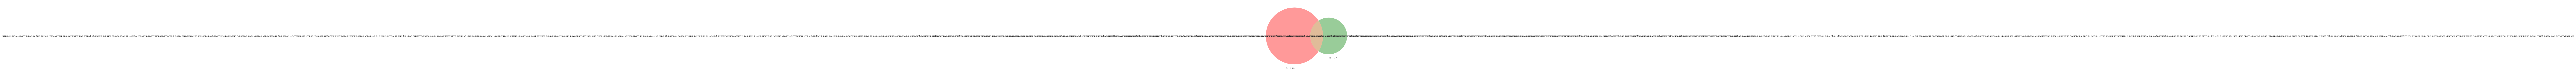

In [28]:
the_input = "ⲟ"
the_output = "ⲱ"

thither = df_diff[(df_diff["input"] == the_input) & (df_diff["output"] == the_output)]
context_thither = set(thither["context_left"].values) | set(thither["context_right"].values)

thence = df_diff[(df_diff["input"] == the_output) & (df_diff["output"] == the_input)]
context_thence = set(thence["context_left"].values) | set(thence["context_right"].values)

v = venn2([context_thither, context_thence], (f"{the_input} → {the_output}", f"{the_output} → {the_input}"))

v.get_label_by_id("10").set_text(" ".join(context_thither - context_thence))
v.get_label_by_id("11").set_text(" ".join(context_thither & context_thence))
v.get_label_by_id("01").set_text(" ".join(context_thence - context_thither))

In [29]:
thence[thence["context_left"] == "ⲡ"]

,greek_lemma,orthography,dialect,date_approximate,input,output,context_left,context_right
id,,,,,,,,
